# KLNX methodology

## Import libraries

In [1]:
# General libraries
import pandas as pd
import numpy as np

# Ploting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import graphviz

# Scikit learn support functions
from sklearn.manifold import MDS
from sklearn import mixture
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Scikit learn models
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Miscoding libraries
from nescience.miscoding import Miscoding
from nescience.classifier import Classifier

# File with the selected attributes
from attribute_file import *

sn.set_theme()

## Load dataset

In [2]:
data = pd.read_csv("../../data/IMDEA.Umlaut.Q1.single.row.csv", encoding = "ISO-8859-1", sep=";", decimal=',')
data = data[data['Test.Type'] == 'HTTP FILE DL']
data = data[data['Test.Qualifier'] == 'QUALIFIED']
data = data[data["Technology"] == "LTE"]
data = data[attributes]
data = data.select_dtypes(['number'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1730 entries, 11 to 21628
Columns: 445 entries, Session.Duration.s to Abs_PacketLost_Acc_TimeStep_20480ms
dtypes: float64(394), int64(51)
memory usage: 5.9 MB


/home/juan/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (41,44,177,179,182,185,195,230,1036,1041,1042,1061,1062) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Preprocessing stage

### Remove features with a large number of null cell (NaN)

In [3]:
data = data.replace([np.inf, -np.inf], np.nan)
data["Nans"] = data.isnull().sum(axis=1)
nans_col = data.isnull().sum(axis=0)

# Extract rows with a large number of nans
data_norm = (data["Nans"] - data.mean()["Nans"])/data.std()["Nans"]
Q3  = data_norm.quantile(0.75) - data_norm.median()
deviations = data["Nans"] - data.median()["Nans"]
MAD = (1/Q3) * deviations.abs().median()
med = data.median()["Nans"]
threshold = med + (3 * MAD)
data_aux = data[data["Nans"] > threshold]
nans_col = data_aux.isnull().sum(axis=0)
data = data.drop(nans_col[nans_col.values != 0].index, axis=1).drop(["Nans"], axis=1)
data = data.dropna(axis=1)
data.shape

(1730, 61)

### Remove features with low variability

In [4]:
# Remove columns with std = 0
data = data.loc[:, (data.std(axis=0) != 0).values]
# Remove columns with IQR = 0
IQR = []
for col in data.columns:  
    Q1, Q3 = data[col].quantile([0.25, 0.75])
    IQR.append(Q3 - Q1 != 0)
data = data.loc[:, IQR]
if 'tcp.first.sec.volume.dl' in data:
    data['tcp.first.sec.volume.dl'] = data['tcp.first.sec.volume.dl'].astype(float)
data.shape

(1730, 33)

### Remove features with a large number of outliers

In [5]:
# Discard columns with high number of outliers (This dataset shall be used to TEST the decision tree)
cols_outliers = {}
for col in data.columns:
    data_nrm = data[col]/data[col].std()
    Q3  = data_nrm.quantile(0.75) - data_nrm.median()
    med = data[col].median()
    dev = data[col] - med
    MAD = (1/Q3) * dev.abs().median()
    if (MAD != 0):
        cols_outliers[col] = [np.sum(data[col] < med - (3 * MAD)) + np.sum(data[col] > med + (3 * MAD))]
    if (MAD == 0):
        cols_outliers[col] = 0

data_tmp = np.vstack(list(cols_outliers.values()))
data_nrm = data_tmp/np.std(data_tmp)
Q3  = np.quantile(data_nrm,0.75) - np.median(data_nrm)
med = np.median(data_tmp)
dev = np.subtract(data_tmp, med)
MAD = (1/Q3) * np.median(np.abs(dev))
data = data.drop([k for k,v in cols_outliers.items() if v > med + (3 * MAD)], axis=1)
data.shape

(1730, 30)

## Training set preparation

### Discards experiments with a large number of outliers

In [6]:
# Discard rows with high number of outliers (This dataset shall be used to TRAIN the decision tree)
data["N_outlier"] = 0
for col in data.columns:
    data_nrm = data[col]/data[col].std()
    Q3 = data_nrm.quantile(0.75) - data_nrm.median()
    med = data[col].median()
    dev = data[col] - med
    MAD = (1/Q3) * dev.abs().median()
    if (MAD != 0):
        data.loc[(data[col]<= med - (3 * MAD)) | (data[col]>= med + (3 * MAD)), 'N_outlier'] += 1    
#print(np.unique(data["N_outlier"], return_counts=True))
data_non_outliers = data.loc[data["N_outlier"] == 0].drop("N_outlier", axis=1)
data = data.drop("N_outlier", axis=1)
data_non_outliers.shape

(1294, 30)

### Feature selection based on model-based clustering

/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


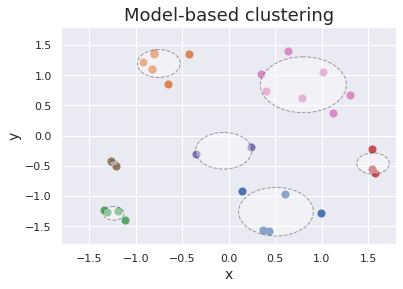

In [7]:
data_non_outliers = data_non_outliers.loc[:, (data_non_outliers.std(axis=0) != 0).values]
corr_matrix = 1 - data_non_outliers.corr(method="pearson").abs()
transformed_samples = MDS(n_components=2, dissimilarity='euclidean', random_state=42).fit_transform(corr_matrix)

cov_type = "spherical"
lowest_bic = np.infty
bic = []
n_components_range = range(1, int(corr_matrix.shape[0]/3))
for n_components in n_components_range:
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=5901)
    # gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=123)
    gmm.fit(transformed_samples)
    bic.append(gmm.bic(transformed_samples))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm
bic = np.array(bic)
clf = best_gmm
classification_non_out = clf.predict(transformed_samples)
centroids_non_out      = clf.means_
cov_non_out            = clf.covariances_
classes = np.unique(classification_non_out)

fig = plt.figure()
ax = fig.add_subplot()
for clusters in range(classes.shape[0]):
    plt.scatter(transformed_samples[classification_non_out == classes[clusters],0],
                transformed_samples[classification_non_out == classes[clusters],1],
                s = 50)
col = []
for index in range(classes.shape[0]):
    col.append(list(plt.cm.tab10(index)))

for uu in range(classes.shape[0]):
    if cov_type == "full":
        covariances = cov_non_out[uu][:2, :2]
    elif cov_type == "tied":
        covariances = cov_non_out[:2, :2]
    elif cov_type == "diag":
        covariances = np.diag(cov_non_out[uu][:2])
    elif cov_type == "spherical":
        covariances = np.eye(centroids_non_out.shape[1]) * cov_non_out[uu]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(centroids_non_out[uu, :2], 
                              v[0],
                              v[1], 
                              180 + angle, 
                              edgecolor='black', 
                              facecolor='white',
                              ls ='--')
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.35)
    ax.add_artist(ell)
#    ax.set_aspect("equal", "datalim")

plt.xlim(-1.80,1.80)
plt.ylim(-1.80,1.80)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title('Model-based clustering', fontsize=18)
plt.savefig('images/clustering2D_realdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()


closest_non_out = [pairwise_distances_argmin_min(centroids_non_out[:][int(n_class)].reshape(1, -1), transformed_samples[np.where(classification_non_out == n_class)])[0] for n_class in np.unique(classification_non_out)] 
corr_columns_non_out = np.array(corr_matrix.columns.values)
final_cols_non_out = [corr_columns_non_out[np.where(classification_non_out == n_class)][int(closest_non_out[index])] for index, n_class in enumerate(np.unique(classification_non_out))]
final_cols_non_out = np.delete(final_cols_non_out, classification_non_out[0])

### KPI discretization

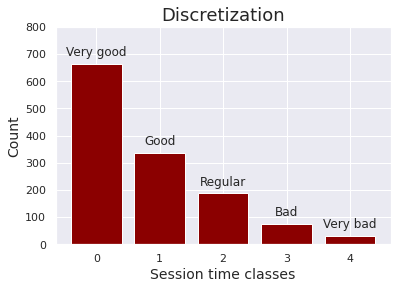

In [8]:
y_train = data_non_outliers["Session.Duration.s"].values
y_train = y_train.reshape(-1, 1)
n_bins = int(np.log2(len(y_train))/2)

disc_model = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')
disc_model.fit(y_train)
yd = disc_model.transform(y_train)
yd = yd[:,0]

val, count = np.unique(yd, return_counts=True)
labels = ['Very good', 'Good', 'Regular', 'Bad', 'Very bad']
plt.bar(x=val, height=count, color='darkred')
plt.xlabel("Session time classes", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.ylim(0,800)
plt.title('Discretization', fontsize=18)
for ii in range(len(val)):
    plt.text(val[ii],count[ii]+30,labels[ii],horizontalalignment='center', fontsize=12)
plt.savefig('images/discretization_realdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()

### Knowledge model training

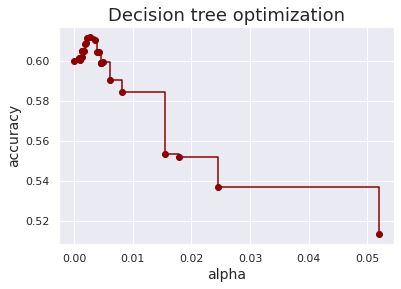

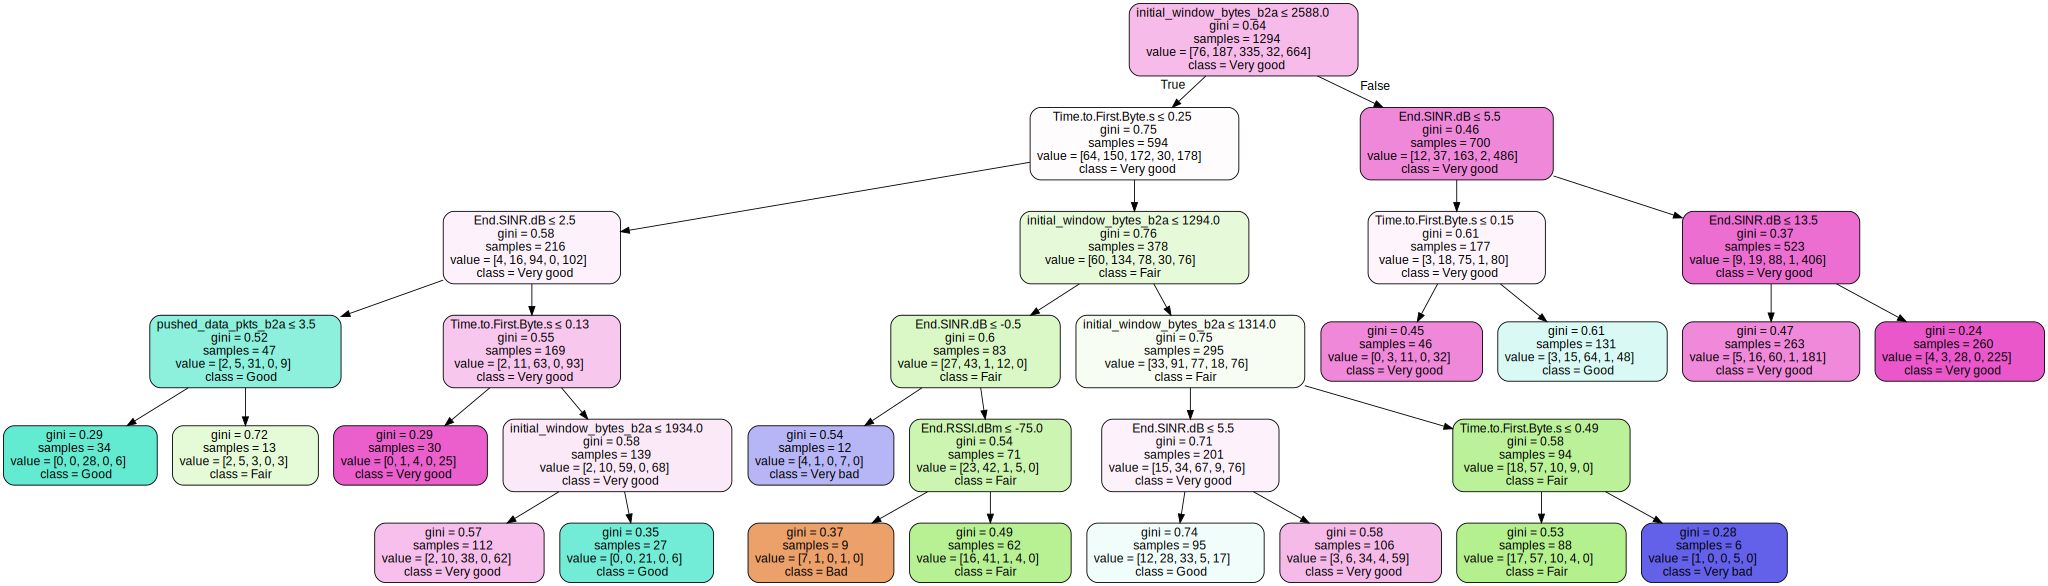

In [9]:
X_train = data_non_outliers[final_cols_non_out].copy()
depth = int(np.log2(len(y_train))/2)
clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5)
path = clf.cost_complexity_pruning_path(X_train, yd)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5, ccp_alpha=ccp_alpha)
    clf.fit(X_train, yd)
    clfs.append(clf)
scores = [cross_val_score(clf, X_train, yd, cv=30, n_jobs=-1).mean() for clf in clfs]

plt.figure()
plt.plot(ccp_alphas, scores, marker='o', drawstyle="steps-post", color='darkred')
plt.xlabel("alpha", fontsize=14)
plt.ylabel("accuracy", fontsize=14)
plt.title("Decision tree optimization", fontsize=18)
plt.savefig('images/model1_optimization_realdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()

best_alpha = ccp_alphas[np.where(scores == np.max(scores))[0][0]]
len(ccp_alphas), np.where(scores == np.max(scores))[0][0], best_alpha
knowledge = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5, ccp_alpha=best_alpha)
knowledge.fit(X_train, yd)

bins = disc_model.bin_edges_[0].tolist()
labels = ['Very good', 'Good', 'Fair', 'Bad', 'Very bad']
data1= pd.cut(x=y_train.reshape(-1), bins = bins, labels=labels, include_lowest=True)
knowledge_label = DecisionTreeClassifier(max_depth=n_bins, min_samples_leaf=5, ccp_alpha=best_alpha)
knowledge_label.fit(X_train, data1)

dot_data = tree.export_graphviz(knowledge_label, 
                                feature_names = np.array(X_train.columns), 
                                class_names=knowledge_label.classes_, 
                                filled=True, 
                                rounded=True, 
                                out_file=None,
                                precision=2,
                                special_characters=True)

graph = graphviz.Source(dot_data)
#graph.format='eps'
graph.format='png'
filename = graph.render(filename='models/model1_realdata')
graph

## Feature Selection based on the miscoding metric

### Vector of anomalous scenarios

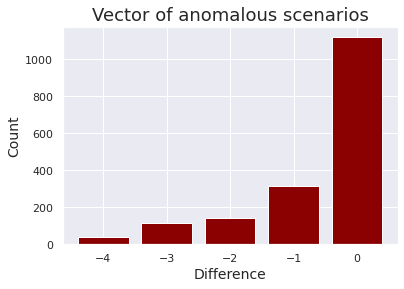

In [10]:
y = data["Session.Duration.s"].values
y = y.reshape(-1, 1)
ydt = disc_model.transform(y)
ydt = ydt[:,0]
y_pred = knowledge.predict(data[final_cols_non_out])
y_diff = y_pred-ydt
y_diff[y_diff > 0] = 0
data["Diff_Pred"] = y_diff

val, count = np.unique(y_diff, return_counts=True)
plt.bar(x=val, height=count, color='darkred')
plt.ylabel("Count", fontsize=14)
plt.xlabel("Difference", fontsize=14)
plt.title("Vector of anomalous scenarios", fontsize=18)
plt.savefig('images/Vanm_realdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()

## Miscoding

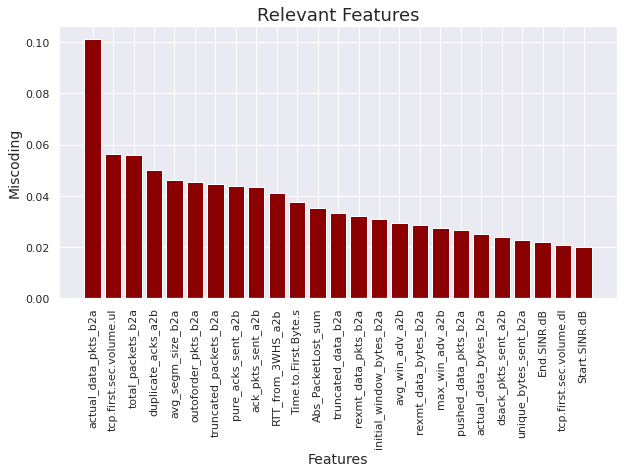

In [11]:
data_misc = data.drop(columns =["Session.Duration.s", "Diff_Pred"])
column_names = np.array(data_misc.columns)
n_clusters  = int(np.log2(len(data.index))/2)
n_features = min(n_clusters * n_clusters, len(data_misc.columns))
miscoding = Miscoding(redundancy=True)
miscoding.fit(data_misc, data["Diff_Pred"])
mscd = miscoding.miscoding_features()

plt.figure(figsize=(10,5))
plt.bar(x=np.arange(0, len(np.argsort(-mscd)[0:n_features])), height=mscd[np.argsort(-mscd)[0:n_features]], color='darkred')
plt.xticks(np.arange(0, len(np.argsort(-mscd)[0:n_features])), column_names[np.argsort(-mscd)[0:n_features]], rotation='vertical')
plt.xlabel("Features", fontsize=14)
plt.ylabel("Miscoding", fontsize=14)
plt.title("Relevant Features", fontsize=18)
plt.savefig('images/miscoding_realdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()

best_mscd = np.argsort(-mscd)[0:n_features]
best_mscd = best_mscd[best_mscd != 15]
attributes = column_names[best_mscd]

## Identification of problematic attributes and experiments

-------------------------------------------
Selection of problematic attributes
Anomaly desity: -0.6318. Threshold: -1.2636.
-------------------------------------------
              Attribute  best_model   Class_1   Class_2
0    duplicate_acks_a2b  best_model  0.090173  0.909827
1   outoforder_pkts_b2a  best_model  0.057803  0.942197
2    pure_acks_sent_a2b  best_model  0.101734  0.898266
3     ack_pkts_sent_a2b  best_model  0.101734  0.898266
4  Time.to.First.Byte.s  best_model  0.019653  0.980347
5    Abs_PacketLost_sum  best_model  0.057225  0.942775
6       avg_win_adv_a2b  best_model  0.110405  0.889595


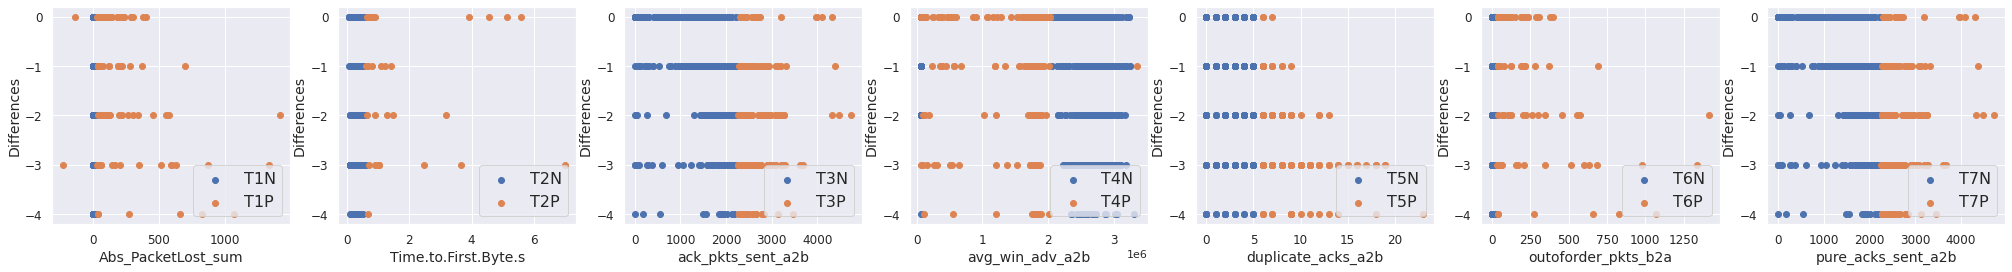

In [12]:
models = pd.DataFrame({"Attribute":pd.Series(dtype='str'),
                        "best_model":pd.Series(dtype='str'),
                        "Class_1":pd.Series(dtype='float'),
                        "Class_2":pd.Series(dtype='float')})
threshold = 2.00 * y_diff.mean()
k=0
print('-------------------------------------------')
print('Selection of problematic attributes')
print('Anomaly desity: %.4f. Threshold: %.4f.'%(y_diff.mean(), threshold))
print('-------------------------------------------')
for i in range(len(attributes)):
    #print(attributes[i])
    attr = data[attributes[i]]
    scaler = StandardScaler()
    scaler.fit(attr.values.reshape(-1, 1))
    data2prc = scaler.transform(attr.values.reshape(-1, 1))

    cov_type = "spherical"
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 4)
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=584)
        gmm.fit(data2prc)
        bic.append(gmm.bic(data2prc))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
    bic = np.array(bic)
    clf = best_gmm
    clustering = clf.predict(data2prc)
    classes = np.unique(clustering)
    class_problem = np.zeros(clustering.shape)
    
    if (classes.shape[0] > 1):
        for ii in range(classes.shape[0]):
            ratio = y_diff[clustering==classes[ii]].mean()
            #print(ratio)
            if ((ratio <= threshold) & (clustering[clustering==classes[ii]].shape[0] > 0.01*clustering.shape[0])):
                class_problem[clustering==classes[ii]]=1
            else:
                class_problem[clustering==classes[ii]]=2
        problem_classes = np.unique(class_problem)
        if (problem_classes.shape[0] > 1):
            if (k==0):
                cls_mat = class_problem.reshape(-1,1)
            else:
                cls_mat= np.hstack((cls_mat, class_problem.reshape(-1,1)))
            k=k+1            
            counts = np.array([class_problem[class_problem==1].shape[0], class_problem[class_problem==2].shape[0]])
            total  = np.sum(counts)
            models = models.append({'Attribute':attributes[i],
                                    'best_model':'best_model',
                                    'Class_1':counts[0]/total,
                                    'Class_2':counts[1]/total},ignore_index=True)
print(models)      


attributes = models["Attribute"].values
attributes, att_ind = np.unique(attributes, return_index=True)
cls_mat = cls_mat[:,att_ind]


nfig = attributes.shape[0]
ncol = 7
nrow = (nfig//ncol) + 1

fig = plt.figure(figsize=(35,4))
k = 0;
for attr in attributes:
    cls_vec = cls_mat[:,k]
    bl_vec1 = (cls_vec==1)
    bl_vec2 = (cls_vec==2)
    
    axes = fig.add_subplot(1,7,k+1)
    plt.scatter(data[attr][bl_vec2], data["Diff_Pred"][bl_vec2], label='T%dN'%(k+1))
    plt.scatter(data[attr][bl_vec1], data["Diff_Pred"][bl_vec1], label='T%dP'%(k+1))
    plt.legend(fontsize=16, loc='lower right' )

    
    plt.xlabel(attr, fontsize=14)
    plt.ylabel("Differences", fontsize=14)
    plt.yticks([-4, -3, -2, -1, 0], fontsize=12)
    plt.xticks(fontsize=12)
    k = k+1

plt.savefig('images/prob_identification_realdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()    

## Generation of anomaly classification labels 

In [13]:
problem = np.empty(cls_mat.shape[0], dtype=object)
separator = ';'
for ii in range(cls_mat.shape[0]):    
    strings = []
    for jj in range(cls_mat.shape[1]):
        if (cls_mat[ii,jj] == 1):
            strings = strings + ['T%dP'%(jj+1)]
        if (cls_mat[ii,jj] == 2):
            strings = strings + ['T%dN'%(jj+1)]
    problem[ii] = separator.join(strings)    

## Building the anomaly classification engine

/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/juan/anaconda3

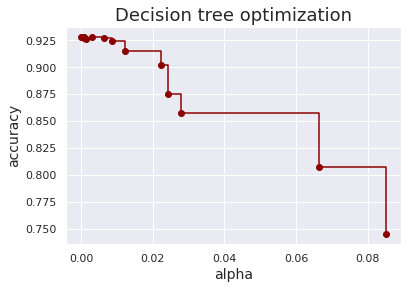

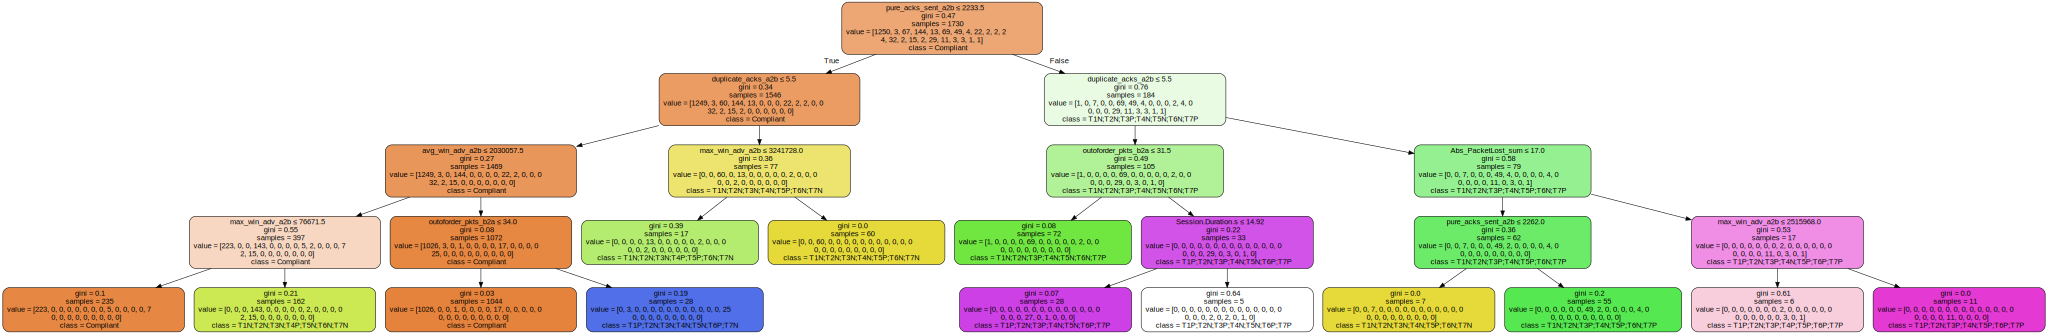

In [14]:
X = data.copy()
X['Problem'] = problem
X.loc[X.Problem.str.contains('^[^P]+$'), "Problem"] = "Compliant"    
fX = X.copy()
fy = fX["Problem"]
fX = fX.drop(["Problem", "Diff_Pred"], axis=1)
depth = int(np.log2(np.sum(fy != "Compliant"))/2)

clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5)
path = clf.cost_complexity_pruning_path(fX, fy)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5, ccp_alpha=ccp_alpha)
    clf.fit(fX, fy)
    clfs.append(clf)
scores = [cross_val_score(clf, fX, fy, cv=5, n_jobs=-1).mean() for clf in clfs]

plt.figure()
plt.plot(ccp_alphas, scores, marker='o', drawstyle="steps-post", color='darkred')
plt.xlabel("alpha", fontsize=14)
plt.ylabel("accuracy", fontsize=14)
plt.title("Decision tree optimization", fontsize=18)
plt.savefig('images/model2_optimization_realdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()


best_alpha = ccp_alphas[np.where(scores == np.max(scores))[0][0]]
len(ccp_alphas), np.where(scores == np.max(scores))[0][0], best_alpha
classifier = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5, ccp_alpha=best_alpha)
classifier.fit(fX, fy)

dot_data = tree.export_graphviz(classifier, 
                                feature_names = np.array(fX.columns), 
                                class_names=classifier.classes_, 
                                filled=True, 
                                rounded=True, 
                                out_file=None,
                                precision=2,
                                special_characters=True)

graph = graphviz.Source(dot_data)
#graph.format='eps'
graph.format='png'
filename = graph.render(filename='models/model2_realdata')
graph